In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

c:\Users\sky\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch
import torch.nn as nn
import numpy as np

feature_size = 16

def softmax_with_temperature(x, beta, d = 1):
    r'''SFNet: Learning Object-aware Semantic Flow (Lee et al.)'''
    M, _ = x.max(dim=d, keepdim=True)
    x = x - M # subtract maximum value for stability
    exp_x = torch.exp(x/beta)
    exp_x_sum = exp_x.sum(dim=d, keepdim=True)
    return exp_x / exp_x_sum

def soft_argmax(corr, beta=0.02):
    r'''SFNet: Learning Object-aware Semantic Flow (Lee et al.)
    corr : [B, l, hsws, htwt]
    '''
    b,_,h,w = corr.size()
    x_normal = np.linspace(-1,1,feature_size)
    x_normal = nn.Parameter(torch.tensor(x_normal, dtype=torch.float, requires_grad=False))
    y_normal = np.linspace(-1,1,feature_size)
    y_normal = nn.Parameter(torch.tensor(y_normal, dtype=torch.float, requires_grad=False))
    
    corr = softmax_with_temperature(corr, beta=beta, d=1)
    corr = corr.view(-1,h,w,h,w) # (target hxw) x (source hxw)

    grid_x = corr.sum(dim=1, keepdim=False) # marginalize to x-coord. [B, ws, ht, wt]
    x_normal = x_normal.expand(b,w)
    x_normal = x_normal.view(b,w,1,1)
    grid_x = (grid_x*x_normal).sum(dim=1, keepdim=True) # b x 1 x h x w
    
    grid_y = corr.sum(dim=2, keepdim=False) # marginalize to y-coord.
    y_normal = y_normal.expand(b,h)
    y_normal = y_normal.view(b,h,1,1)
    grid_y = (grid_y*y_normal).sum(dim=1, keepdim=True) # b x 1 x h x w

x = torch.rand((4, 256, feature_size, feature_size))

soft_argmax(x)

In [17]:
x = np.random.rand(32, 16, 16)
x = x.reshape(32, -1)
max_idx = np.argmax(x, axis=-1)
max_idx, max_idx//16, max_idx%16

(array([ 41,  33, 227,  34,  99,  61, 242,  93, 225,  50, 124,   6,  71,
         71, 202,   5, 171, 238, 209,  13,  76, 120,  79, 146, 143, 234,
         69, 253, 144,  11, 231,   5], dtype=int64),
 array([ 2,  2, 14,  2,  6,  3, 15,  5, 14,  3,  7,  0,  4,  4, 12,  0, 10,
        14, 13,  0,  4,  7,  4,  9,  8, 14,  4, 15,  9,  0, 14,  0],
       dtype=int64),
 array([ 9,  1,  3,  2,  3, 13,  2, 13,  1,  2, 12,  6,  7,  7, 10,  5, 11,
        14,  1, 13, 12,  8, 15,  2, 15, 10,  5, 13,  0, 11,  7,  5],
       dtype=int64))

0.9990950805708391 0.9990950805708391


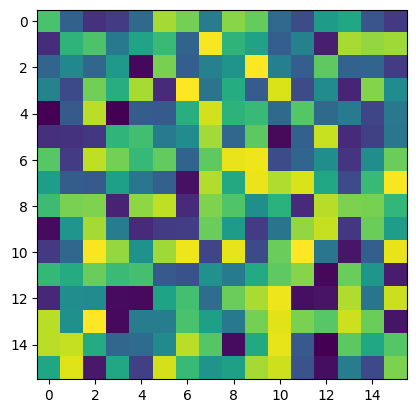

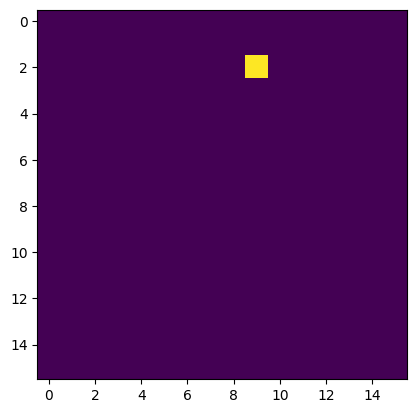

In [25]:
for i in range(16) :
    _x = x[i]
    _x = _x.reshape(16, 16)
    z_x = np.zeros_like(_x)
    r, c = max_idx[i]//16, max_idx[i]%16
    z_x[r, c] = 1.
    print(_x[r, c], _x.max())

    plt.imshow(_x)
    plt.show()
    plt.imshow(z_x)
    plt.show()
    break 



In [5]:
x = torch.rand((32, 64, 64))
x = x.reshape(32, -1)
_, max_idx = torch.max(x, dim=-1, keepdim=True)
tgt_max_row = max_idx // 64
tgt_max_col = max_idx % 64    # [B, Q, 1]

In [13]:
src_heatmap = torch.rand((1, 32, 64*64))
tgt_heatmap = torch.rand((1, 32, 64*64))
h, w, B = 64, 64, 1
_, src_max_idx = torch.max(src_heatmap, dim=-1)   # [B, Q]
src_max_row = src_max_idx // h
src_max_col = src_max_idx % h    # [B, Q]

_, tgt_max_idx = torch.max(tgt_heatmap, dim=-1)   # [B, Q]
tgt_max_row = tgt_max_idx // h
tgt_max_col = tgt_max_idx % h    # [B, Q]
print(tgt_max_col)
flow_map = torch.zeros((B, 2, h, w))   # [B, 2, h, w]
for b in range(B):
    src_row, src_col = src_max_row[b], src_max_col[b]   # [Q]
    tgt_row, tgt_col = tgt_max_row[b], tgt_max_col[b]   # [Q]
    for q in range(32) :
        flow_map[b, 0, tgt_row[q], tgt_col[q]] = src_row[q] - tgt_row[q]
        flow_map[b, 1, tgt_row[q], tgt_col[q]] = src_col[q] - tgt_col[q]

tensor([[38, 50, 35, 49, 35, 18, 22, 16, 31, 37, 43, 11, 47, 31, 59, 59, 39, 24,
          7, 54, 58, 46, 42, 60, 61, 11, 24,  8, 41, 47, 36, 60]])
